In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import joblib
from joblib import load
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import skew
import numpy as np

# Step 1: Load cleaned and normalized dataset
df_model = pd.read_csv('/Users/sa25/Desktop/music-rec-algorithm-TLAB/data/cleaned_dataset.csv')

Model Training

In [4]:
# Step 2: Select the same features standardized earlier
features = df_model.select_dtypes(include=['float64', 'int64'])

# Step 3: Identify skewed columns
skewed_cols = []
for col in features:
    if (df_model[col] > 0).all(): 
        if skew(df_model[col]) > 1:
            skewed_cols.append(col)

print("Skewed columns to transform:", skewed_cols)

Skewed columns to transform: ['len', 'dating', 'violence', 'world/life', 'night/time', 'shake the audience', 'family/gospel', 'romantic', 'communication', 'obscene', 'music', 'movement/places', 'light/visual perceptions', 'family/spiritual', 'sadness', 'feelings']


In [5]:
# Step 4: Apply log transformation to skewed columns
for col in skewed_cols:
    df_model[f'{col}_log'] = np.log1p(df_model[col])

In [10]:
# Step 5: Dimentionality Reduction by PCA
pca = PCA(n_components=3) 
features_pca = pca.fit_transform(features)

# Step 6: Train KMeans
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(features)

# Step 7: Assign cluster labels to the original dataframe
df_model['cluster'] = kmeans.labels_

# Step 8: Save updated dataframe
df_model.to_csv('/Users/sa25/Desktop/music-rec-algorithm-TLAB/data/clustered_dataset.csv', index=False)

In [11]:
# load raw data set, and combine with df_model dataset (with the additional 'Cluster' column)
df = pd.read_csv("/Users/sa25/Desktop/music-rec-algorithm-TLAB/data/train.csv")

label = df[['genre', 'artist_name', 'track_name', 'release_date']]

label = pd.concat([label, df_model], axis=1)

label.head()

,genre,artist_name,track_name,release_date,release_date,len,dating,violence,world/life,night/time,...,romantic_log,communication_log,obscene_log,music_log,movement/places_log,light/visual perceptions_log,family/spiritual_log,sadness_log,feelings_log,cluster
0,pop,mukesh,mohabbat bhi jhoothi,1950,1950,95,0.000598,0.063746,0.000598,0.000598,...,0.016960,0.234084,0.000598,0.038536,0.000598,0.000598,0.000598,0.322300,0.110804,2
1,pop,frankie laine,i believe,1950,1950,51,0.035537,0.096777,0.443435,0.001284,...,0.001283,0.001283,0.001283,0.111572,0.001283,0.192834,0.049860,0.001283,0.001283,0
2,pop,johnnie ray,cry,1950,1950,24,0.002770,0.002770,0.002770,0.002770,...,0.147182,0.223678,0.002766,0.280502,0.002766,0.002766,0.002766,0.002766,0.203286,0
3,pop,pérez prado,patricia,1950,1950,54,0.048249,0.001548,0.001548,0.001548,...,0.344678,0.001547,0.001547,0.001547,0.121554,0.001547,0.001547,0.203667,0.001547,0
4,pop,giorgos papadopoulos,apopse eida oneiro,1950,1950,48,0.001350,0.001350,0.417772,0.001350,...,0.380783,0.001349,0.001349,0.001349,0.001349,0.001349,0.029320,0.066537,0.001349,0


In [12]:
# Get value count for each cluster
df_model['cluster'].value_counts().sort_index().to_frame(name='Count')

,Count
cluster,
0,14034
1,3935
2,10393


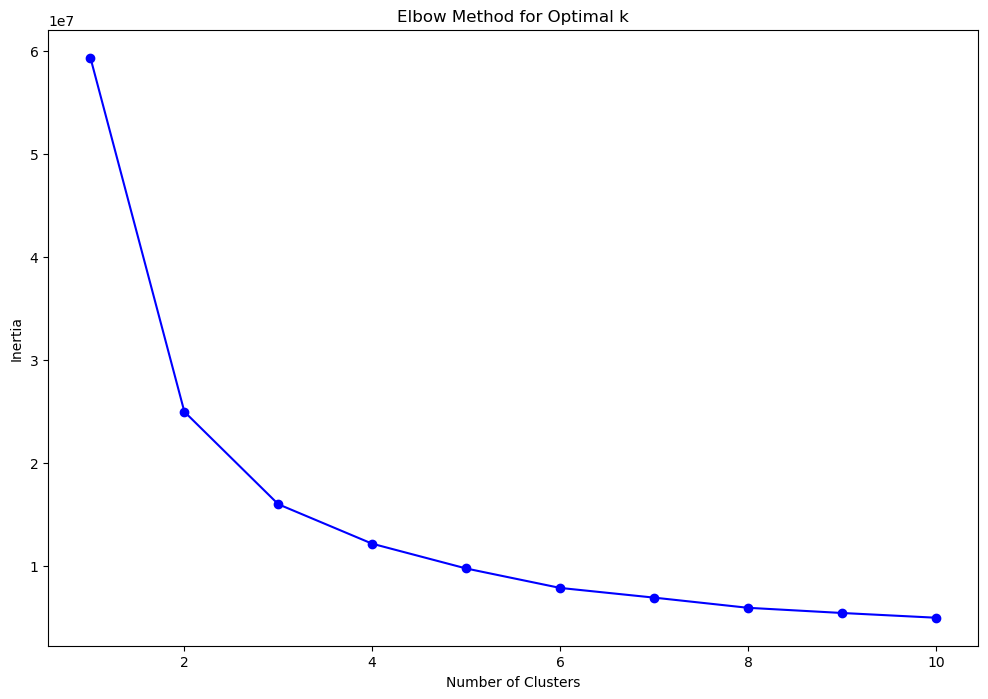

In [13]:
# Step 9: Visualize elbow method to determine best # of clusters
inertia = []
k_range = range(1, 11)
for i in k_range:
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(features)
    inertia.append(km.inertia_)
    
plt.figure(figsize=(12, 8))
plt.plot(k_range, inertia, marker='o', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [14]:
# Step 10: Silhouette Score to determine clustering quality
best_score = -1
best_k = 0
for k in k_range[1:11]:  # Start from 2 to avoid singularity
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    score = silhouette_score(features, kmeans.labels_)
    print(f"Silhouette Score for {k} clusters: {score}")
    
    if score > best_score:
        best_score = score
        best_k = k

print(f"Best # of clusters based on Silhouette Score is: {best_k}")

Silhouette Score for 2 clusters: 0.5261716006338516
Silhouette Score for 3 clusters: 0.40642000461089384
Silhouette Score for 4 clusters: 0.3801647642164433
Silhouette Score for 5 clusters: 0.36239670657926143
Silhouette Score for 6 clusters: 0.3766455554290103
Silhouette Score for 7 clusters: 0.3560677606343255
Silhouette Score for 8 clusters: 0.35891586943297155
Silhouette Score for 9 clusters: 0.3440027671321802
Silhouette Score for 10 clusters: 0.33824775513965954
Best # of clusters based on Silhouette Score is: 2


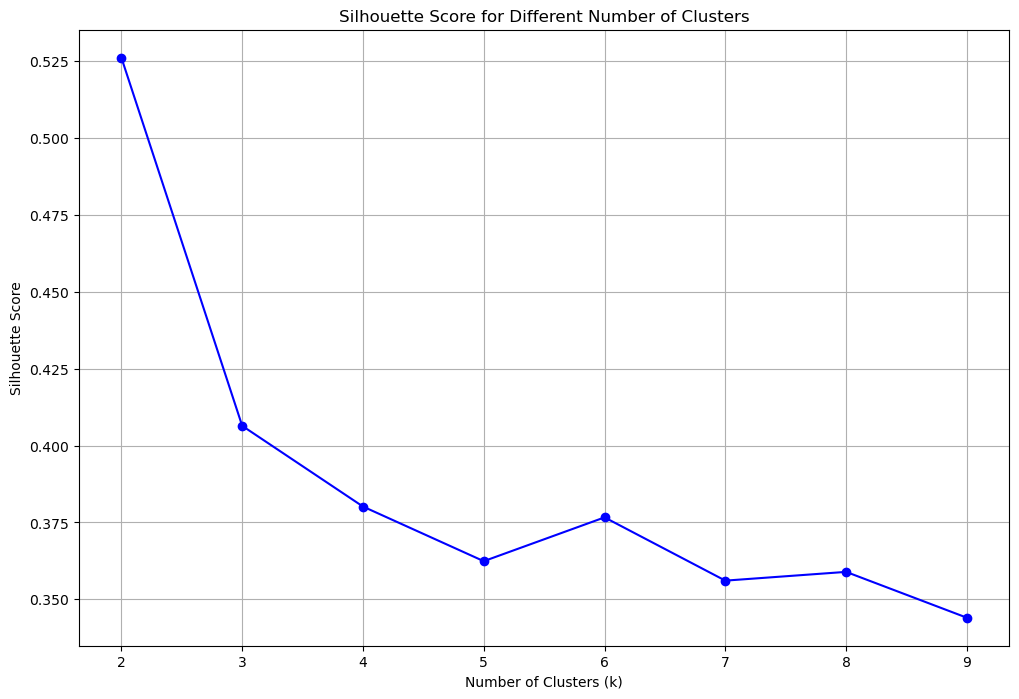

In [89]:
# Initialize list to store silhouette scores
sil_scores = []

# Test different cluster values
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features)  # Get cluster labels for each data point
    
    # Calculate silhouette score for the current number of clusters
    score = silhouette_score(features, cluster_labels)
    sil_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(12, 8))
plt.plot(range(2, 10), sil_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score for Different Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 10)) 
plt.grid(True)
plt.show()

# Silhouette score plot shows a steep drop between 2-3 clusters, so 3 clusters will be used

In [15]:
# Save cluster labels to dataset
kmeans = KMeans(n_clusters=3, random_state=42)
df_model['cluster'] = kmeans.fit_predict(features)

# Save updated dataframe with cluster labels
df_model.to_csv('clustered_training_dataset.csv', index=False)

In [16]:
# Predict the cluster labels using the trained KMeans model
df_model['cluster'] = kmeans.predict(features)  # Predicting the clusters for test data

# Save the KMeans model
joblib.dump(kmeans, 'kmeans_model.joblib')

# Save the updated training dataframe with predicted cluster labels
df_model.to_csv('clustered_training_dataset.csv', index=False)


Testing

In [18]:
# Load the test dataset
df_recommend = pd.read_csv('/Users/sa25/Desktop/music-rec-algorithm-TLAB/data/recommend.csv')

# Step 2: Check the first few rows to understand the data
print(df_recommend.head())

   Unnamed: 0       artist_name           track_name  release_date   genre  \
0       76885          godsmack               immune          1998    rock   
1       65394      dennis brown        second chance          1993  reggae   
2       10980  the black crowes          sister luck          1990     pop   
3         842   jerry lee lewis  your cheating heart          1960     pop   
4        2764         paul anka             eso beso          1966     pop   

                                              lyrics  len    dating  violence  \
0  come world society futher place home land deat...   74  0.000907  0.348191   
1  maybe maybe treat good feel second best girl s...   43  0.001224  0.029943   
2  worry sick eye hurt rest head life outside gir...   54  0.001120  0.482490   
3  cheat heart weep sleep sleep come night cheat ...   25  0.204740  0.002506   
4  beso kiss beso kiss know samba bossanova close...   97  0.001170  0.001170   

   world/life  ...   obscene     music  move

In [19]:
# Select same features for clustering as used in training
df_recommend = df_model.select_dtypes(include=['float64', 'int64']).columns

# Load models and feature list from training
scaler = joblib.load('/Users/sa25/Desktop/music-rec-algorithm-TLAB/data/scaler_model.joblib')
kmeans = joblib.load('/Users/sa25/Desktop/music-rec-algorithm-TLAB/data/kmeans_model.joblib')
numeric_cols = joblib.load('/Users/sa25/Desktop/music-rec-algorithm-TLAB/data/numeric_cols.joblib')

# Select numeric columns from the dataset, using the saved feature list
df_recommend = df_model[numeric_cols].copy()

# Scale and predict
df_recommend_scaled = pd.DataFrame(scaler.transform(df_recommend), columns=numeric_cols)
df_recommend['cluster'] = kmeans.predict(df_recommend_scaled)

# Save output
df_recommend.to_csv('/Users/sa25/Desktop/music-rec-algorithm-TLAB/data/clustered_recommend_dataset.csv', index=False)

Analyze Clusters

In [20]:
# Group by cluster and get means of each feature
df_model.groupby('cluster').mean()

,release_date,len,dating,violence,world/life,night/time,shake the audience,family/gospel,romantic,communication,...,family/gospel_log,romantic_log,communication_log,obscene_log,music_log,movement/places_log,light/visual perceptions_log,family/spiritual_log,sadness_log,feelings_log
cluster,,,,,,,,,,,,,,,,,,,,,
0,1983.978908,41.304760,0.022261,0.099881,0.138047,0.061523,0.013828,0.016962,0.066503,0.081235,...,0.015992,0.058460,0.072570,0.039508,0.061068,0.032914,0.047145,0.022512,0.131216,0.030087
1,1998.718679,155.387548,0.018773,0.118753,0.080069,0.040498,0.025145,0.016640,0.018827,0.064707,...,0.015923,0.017365,0.059616,0.231982,0.035051,0.060396,0.033700,0.022117,0.047234,0.025030
2,1995.483402,84.688829,0.020440,0.143194,0.113434,0.058111,0.019341,0.017311,0.035904,0.074983,...,0.016413,0.032464,0.068071,0.080413,0.047867,0.049840,0.045300,0.023309,0.105639,0.027605


In [21]:
# Same for test dataset
df_recommend.groupby('cluster').mean()

,release_date,len,dating,violence,world/life,night/time,shake the audience,family/gospel,romantic,communication,obscene,music,movement/places,light/visual perceptions,family/spiritual,sadness,feelings,feelings_outlier
cluster,,,,,,,,,,,,,,,,,,
0,1990.239652,73.030534,0.02111,0.118371,0.120984,0.057356,0.017418,0.017045,0.048676,0.076651,0.097185,0.060067,0.047417,0.049008,0.024155,0.129402,0.030995,0.110712


In [22]:
df_model[numeric_cols].describe()

,release_date,len,dating,violence,world/life,night/time,shake the audience,family/gospel,romantic,communication,obscene,music,movement/places,light/visual perceptions,family/spiritual,sadness,feelings,feelings_outlier
count,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000
mean,1990.239652,73.030534,0.021110,0.118371,0.120984,0.057356,0.017418,0.017045,0.048676,0.076651,0.097185,0.060067,0.047417,0.049008,0.024155,0.129402,0.030995,0.110712
std,18.486997,41.831605,0.052366,0.178658,0.172216,0.111892,0.040658,0.041968,0.106071,0.109497,0.181314,0.123346,0.091559,0.089553,0.051032,0.181149,0.071656,0.313780
min,1950.000000,1.000000,0.000291,0.000284,0.000291,0.000289,0.000284,0.000289,0.000284,0.000291,0.000289,0.000289,0.000284,0.000284,0.000284,0.000284,0.000289,0.000000
25%,1975.000000,42.000000,0.000923,0.001120,0.001170,0.001032,0.000993,0.000923,0.000975,0.001144,0.001053,0.000975,0.000993,0.000993,0.000957,0.001144,0.000993,0.000000
50%,1991.000000,63.000000,0.001462,0.002506,0.006579,0.001949,0.001595,0.001504,0.001754,0.002632,0.001815,0.001815,0.001645,0.001815,0.001645,0.005263,0.001754,0.000000
75%,2007.000000,93.000000,0.004049,0.192538,0.197854,0.065778,0.009989,0.004785,0.042304,0.132111,0.088799,0.055109,0.054373,0.064302,0.025515,0.235115,0.032617,0.000000
max,2019.000000,199.000000,0.647706,0.981781,0.962105,0.973684,0.497463,0.545303,0.940789,0.645829,0.992298,0.956938,0.638021,0.667782,0.618073,0.981424,0.958810,1.000000


In [23]:
df_recommend[numeric_cols].describe()


,release_date,len,dating,violence,world/life,night/time,shake the audience,family/gospel,romantic,communication,obscene,music,movement/places,light/visual perceptions,family/spiritual,sadness,feelings,feelings_outlier
count,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000,28362.000000
mean,1990.239652,73.030534,0.021110,0.118371,0.120984,0.057356,0.017418,0.017045,0.048676,0.076651,0.097185,0.060067,0.047417,0.049008,0.024155,0.129402,0.030995,0.110712
std,18.486997,41.831605,0.052366,0.178658,0.172216,0.111892,0.040658,0.041968,0.106071,0.109497,0.181314,0.123346,0.091559,0.089553,0.051032,0.181149,0.071656,0.313780
min,1950.000000,1.000000,0.000291,0.000284,0.000291,0.000289,0.000284,0.000289,0.000284,0.000291,0.000289,0.000289,0.000284,0.000284,0.000284,0.000284,0.000289,0.000000
25%,1975.000000,42.000000,0.000923,0.001120,0.001170,0.001032,0.000993,0.000923,0.000975,0.001144,0.001053,0.000975,0.000993,0.000993,0.000957,0.001144,0.000993,0.000000
50%,1991.000000,63.000000,0.001462,0.002506,0.006579,0.001949,0.001595,0.001504,0.001754,0.002632,0.001815,0.001815,0.001645,0.001815,0.001645,0.005263,0.001754,0.000000
75%,2007.000000,93.000000,0.004049,0.192538,0.197854,0.065778,0.009989,0.004785,0.042304,0.132111,0.088799,0.055109,0.054373,0.064302,0.025515,0.235115,0.032617,0.000000
max,2019.000000,199.000000,0.647706,0.981781,0.962105,0.973684,0.497463,0.545303,0.940789,0.645829,0.992298,0.956938,0.638021,0.667782,0.618073,0.981424,0.958810,1.000000


In [24]:
pd.set_option('display.max_columns', None)
label[df_recommend['cluster'] == 0].sample(15)

,genre,artist_name,track_name,release_date,release_date,len,dating,violence,world/life,night/time,shake the audience,family/gospel,romantic,communication,obscene,music,movement/places,light/visual perceptions,family/spiritual,sadness,feelings,genre_blues,genre_country,genre_hip hop,genre_jazz,genre_pop,genre_reggae,genre_rock,topic_feelings,topic_music,topic_night/time,topic_obscene,topic_romantic,topic_sadness,topic_violence,topic_world/life,feelings_outlier,len_log,dating_log,violence_log,world/life_log,night/time_log,shake the audience_log,family/gospel_log,romantic_log,communication_log,obscene_log,music_log,movement/places_log,light/visual perceptions_log,family/spiritual_log,sadness_log,feelings_log,cluster
22740,reggae,wookiefoot,monkey see monkey do,2009,2009,42,0.001815,0.364340,0.001815,0.001815,0.001815,0.001815,0.001815,0.449315,0.001815,0.001815,0.001815,0.001815,0.001815,0.001815,0.065845,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,0,3.761200,0.001813,0.310671,0.001813,0.001813,0.001813,0.001813,0.001813,0.371091,0.001813,0.001813,0.001813,0.001813,0.001813,0.001813,0.063768,0
26605,rock,mastodon,oblivion,2009,2009,91,0.000658,0.058607,0.000658,0.085067,0.000658,0.000658,0.000658,0.072539,0.000658,0.149857,0.000658,0.154168,0.000658,0.427139,0.000658,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,0,4.521789,0.000658,0.056954,0.000658,0.081642,0.000658,0.000658,0.000658,0.070029,0.000658,0.139637,0.000658,0.143380,0.000658,0.355672,0.000658,2
13291,blues,otis redding,(sittin' on) the dock of the bay,1968,1968,73,0.000957,0.000957,0.125325,0.000957,0.019308,0.000957,0.000957,0.000957,0.428165,0.045226,0.000957,0.000957,0.000957,0.169292,0.000957,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,0,4.304065,0.000956,0.000956,0.118072,0.000956,0.019124,0.000956,0.000956,0.000956,0.356390,0.044233,0.000956,0.000956,0.000956,0.156399,0.000956,2
24793,rock,u2,wire,1984,1984,66,0.000957,0.274875,0.061674,0.151104,0.000957,0.000957,0.021363,0.000957,0.000957,0.000957,0.000957,0.000957,0.000957,0.317267,0.000957,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,0,4.204693,0.000956,0.242848,0.059847,0.140721,0.000956,0.000956,0.021138,0.000956,0.000956,0.000956,0.000956,0.000956,0.000956,0.275559,0.000956,2
6436,pop,trevor hall,green mountain state,2014,2014,30,0.002024,0.500376,0.002024,0.002024,0.079554,0.002024,0.002024,0.002024,0.002024,0.136404,0.002024,0.158571,0.002024,0.096754,0.002024,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,0,3.433987,0.002022,0.405716,0.002022,0.002022,0.076548,0.002022,0.002022,0.002022,0.002022,0.127869,0.002022,0.147188,0.002022,0.092355,0.002022,0
24939,rock,honeymoon suite,what does it take,1986,1986,35,0.001595,0.001595,0.321556,0.001595,0.001595,0.076617,0.001595,0.356119,0.001595,0.001595,0.001595,0.081256,0.027208,0.001595,0.001595,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,0,3.583519,0.001594,0.001594,0.278810,0.001594,0.001594,0.073823,0.001594,0.304627,0.001594,0.001594,0.001594,0.078123,0.026844,0.001594,0.001594,0
24651,rock,slayer,evil has no boundaries,1983,1983,63,0.001504,0.722700,0.071473,0.067365,0.001504,0.001504,0.001504,0.001504,0.001504,0.001504,0.001504,0.064181,0.001504,0.001504,0.001504,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,0,4.158883,0.001503,0.543893,0.069035,0.065193,0.001503,0.001503,0.001503,0.001503,0.001503,0.001503,0.001503,0.062206,0.001503,0.001503,0.001503,0
1059,pop,judy collins,in my life,1966,1966,44,0.001284,0.027975,0.392188,0.001284,0.001284,0.001284,0.076894,0.302666,0.001284,0.001284,0.001284,0.001284,0.001284,0.001284,0.057431,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,0,3.806662,0.001283,0.027590,0.330876,0.0

In [25]:
df_model.groupby('cluster').count()

,release_date,len,dating,violence,world/life,night/time,shake the audience,family/gospel,romantic,communication,obscene,music,movement/places,light/visual perceptions,family/spiritual,sadness,feelings,genre_blues,genre_country,genre_hip hop,genre_jazz,genre_pop,genre_reggae,genre_rock,topic_feelings,topic_music,topic_night/time,topic_obscene,topic_romantic,topic_sadness,topic_violence,topic_world/life,feelings_outlier,len_log,dating_log,violence_log,world/life_log,night/time_log,shake the audience_log,family/gospel_log,romantic_log,communication_log,obscene_log,music_log,movement/places_log,light/visual perceptions_log,family/spiritual_log,sadness_log,feelings_log
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034,14034
1,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935,3935
2,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393,10393


In [26]:
label[df_model['cluster'] == 0].sample(10)

,genre,artist_name,track_name,release_date,release_date,len,dating,violence,world/life,night/time,shake the audience,family/gospel,romantic,communication,obscene,music,movement/places,light/visual perceptions,family/spiritual,sadness,feelings,genre_blues,genre_country,genre_hip hop,genre_jazz,genre_pop,genre_reggae,genre_rock,topic_feelings,topic_music,topic_night/time,topic_obscene,topic_romantic,topic_sadness,topic_violence,topic_world/life,feelings_outlier,len_log,dating_log,violence_log,world/life_log,night/time_log,shake the audience_log,family/gospel_log,romantic_log,communication_log,obscene_log,music_log,movement/places_log,light/visual perceptions_log,family/spiritual_log,sadness_log,feelings_log,cluster
4503,pop,blur,beetlebum,1997,1997,43,0.001645,0.001645,0.001645,0.001645,0.001645,0.001645,0.001645,0.001645,0.001645,0.001645,0.001645,0.001645,0.035935,0.652336,0.285413,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,1,3.784190,0.001643,0.001643,0.001643,0.001643,0.001643,0.001643,0.001643,0.001643,0.001643,0.001643,0.001643,0.001643,0.035304,0.502190,0.251080,0
11425,country,cross canadian ragweed,leave me alone,2004,2004,49,0.001316,0.392793,0.001316,0.001316,0.001316,0.001316,0.001316,0.331565,0.194327,0.061578,0.001316,0.001316,0.001316,0.001316,0.001316,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,0,3.912023,0.001315,0.331311,0.001315,0.001315,0.001315,0.001315,0.001315,0.286355,0.177583,0.059756,0.001315,0.001315,0.001315,0.001315,0.001315,0
17102,jazz,george shearing,september in the rain,1950,1950,38,0.002024,0.002024,0.002024,0.002024,0.002024,0.002024,0.002024,0.002024,0.002024,0.716694,0.002024,0.002024,0.002024,0.073479,0.002024,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,0,3.663562,0.002022,0.002022,0.002022,0.002022,0.002022,0.002022,0.002022,0.002022,0.002022,0.540400,0.002022,0.002022,0.002022,0.070905,0.002022,0
12825,blues,ella fitzgerald,love walked in,1959,1959,27,0.002105,0.002105,0.188245,0.063128,0.002105,0.002105,0.002105,0.149472,0.002105,0.002105,0.002105,0.092138,0.033628,0.300590,0.002105,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,0,3.332205,0.002103,0.002103,0.172478,0.061215,0.002103,0.002103,0.002103,0.139303,0.002103,0.002103,0.002103,0.088137,0.033075,0.262818,0.002103,0
9439,country,johnny cash,we must believe in magic,1982,1982,31,0.003289,0.003289,0.373682,0.003289,0.003289,0.003289,0.003289,0.003289,0.003289,0.003289,0.003289,0.432990,0.003289,0.003289,0.003289,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,0,3.465736,0.003284,0.003284,0.317495,0.003284,0.003284,0.003284,0.003284,0.003284,0.003284,0.003284,0.003284,0.359763,0.003284,0.003284,0.003284,0
17655,jazz,dean martin,hands across the table,1964,1964,30,0.002105,0.002105,0.002105,0.002105,0.002105,0.088361,0.349067,0.148909,0.002105,0.002105,0.197207,0.104114,0.002105,0.002105,0.002105,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,0,3.433987,0.002103,0.002103,0.002103,0.002103,0.002103,0.084673,0.299413,0.138813,0.002103,0.002103,0.179992,0.099043,0.002103,0.002103,0.002103,0
588,pop,bob dylan,"baby, let me follow you down",1962,1962,55,0.242167,0.125783,0.340901,0.001422,0.001422,0.001422,0.001422,0.001422,0.001422,0.182550,0.001422,0.060892,0.001422,0.029215,0.001422,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,0,4.025352,0.216858,0.118479,0.293342,0.001421,0.001421,0.001421,0.001421,0.001421,0.001421,0.167673,0.001421,0.059110,0.001421,0.028796,0.001421,0
19782,jazz,jamie cullum,i get a kick out of you,2004,2004,59,0.001284,0.001284,0.001284,0.001284,0.001284,0.001284,0.119184,0.001284,0.436489,0.001284,0.423789,0.001284,0.001284,0.001284,0.001284,False,False,False,True,False,False,False,False,False,False,True,False,False,Fals

In [27]:
label[df_model['cluster'] == 1].sample(10)

,genre,artist_name,track_name,release_date,release_date,len,dating,violence,world/life,night/time,shake the audience,family/gospel,romantic,communication,obscene,music,movement/places,light/visual perceptions,family/spiritual,sadness,feelings,genre_blues,genre_country,genre_hip hop,genre_jazz,genre_pop,genre_reggae,genre_rock,topic_feelings,topic_music,topic_night/time,topic_obscene,topic_romantic,topic_sadness,topic_violence,topic_world/life,feelings_outlier,len_log,dating_log,violence_log,world/life_log,night/time_log,shake the audience_log,family/gospel_log,romantic_log,communication_log,obscene_log,music_log,movement/places_log,light/visual perceptions_log,family/spiritual_log,sadness_log,feelings_log,cluster
25618,rock,dc talk,what if i stumble?,1995,1995,137,0.000591,0.215870,0.181896,0.000591,0.000591,0.023836,0.018002,0.000591,0.000591,0.000591,0.000591,0.000591,0.034035,0.518673,0.000591,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,0,4.927254,0.000591,0.195460,0.167120,0.000591,0.000591,0.023557,0.017842,0.000591,0.000591,0.000591,0.000591,0.000591,0.033469,0.417837,0.000591,1
28217,hip hop,lil scrappy,be real,2018,2018,199,0.000439,0.152067,0.037386,0.000439,0.000439,0.042551,0.012221,0.000439,0.535913,0.000439,0.079043,0.000439,0.021960,0.053348,0.025831,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,0,5.298317,0.000439,0.141558,0.036704,0.000439,0.000438,0.041671,0.012147,0.000439,0.429125,0.000439,0.076075,0.000439,0.021723,0.051974,0.025503,1
21884,reggae,musical youth,"mash it to the youth man, mash it",1994,1994,141,0.000470,0.309852,0.000470,0.099458,0.000470,0.000470,0.000470,0.000470,0.292392,0.000470,0.000470,0.000470,0.025113,0.109102,0.096935,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,1,4.955827,0.000470,0.269914,0.000470,0.094817,0.000470,0.000470,0.000470,0.000470,0.256494,0.000470,0.000470,0.000470,0.024803,0.103550,0.092520,1
5504,pop,troy,get'cha head in the game,2006,2006,158,0.000675,0.269044,0.000675,0.000675,0.000675,0.000675,0.000675,0.217704,0.447649,0.000675,0.000675,0.000675,0.000675,0.000675,0.000675,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,0,5.068904,0.000675,0.238264,0.000675,0.000675,0.000675,0.000675,0.000675,0.196967,0.369941,0.000675,0.000675,0.000675,0.000675,0.000675,0.000675,1
2800,pop,kenny loggins,heartlight,1982,1982,138,0.000585,0.000585,0.014165,0.000585,0.000585,0.011943,0.000585,0.000585,0.000585,0.012153,0.000585,0.471389,0.000585,0.447177,0.000585,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,0,4.934474,0.000585,0.000585,0.014065,0.000585,0.000585,0.011872,0.000585,0.000585,0.000585,0.012080,0.000585,0.386207,0.000585,0.369615,0.000585,1
20574,jazz,chinese man,the journey,2015,2015,154,0.000578,0.048538,0.074688,0.041881,0.000578,0.054383,0.000578,0.146389,0.332900,0.000578,0.056710,0.167627,0.046922,0.000578,0.000578,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,0,5.043425,0.000578,0.047396,0.072030,0.041028,0.000578,0.052956,0.000578,0.136617,0.287357,0.000578,0.055161,0.154974,0.045854,0.000578,0.000578,1
22288,reggae,beenie man,party hard,2002,2002,170,0.000526,0.000526,0.000526,0.030498,0.000526,0.000526,0.013690,0.000526,0.391189,0.027256,0.233147,0.000526,0.000526,0.108138,0.000526,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,0,5.141664,0.000526,0.000526,0.000526,0.030042,0.000526,0.000526,0.013597,0.000526,0.330159,0.026891,0.209569,0.000526,0.000526,0.102681,0.000526,1
27953,hip hop,abstract rude,3d nights,2015,2015,187,0.000566,0.430309,0.000566,0.000566,0.000566,0.012353,0.085400,0.000566,0.000566,0.000566,0.000566,0.376742,0.000566,0.050090,0.000566,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,0,5.236442,0.000566,0.357890,

In [28]:
label[df_model['cluster'] == 2].sample(10)

,genre,artist_name,track_name,release_date,release_date,len,dating,violence,world/life,night/time,shake the audience,family/gospel,romantic,communication,obscene,music,movement/places,light/visual perceptions,family/spiritual,sadness,feelings,genre_blues,genre_country,genre_hip hop,genre_jazz,genre_pop,genre_reggae,genre_rock,topic_feelings,topic_music,topic_night/time,topic_obscene,topic_romantic,topic_sadness,topic_violence,topic_world/life,feelings_outlier,len_log,dating_log,violence_log,world/life_log,night/time_log,shake the audience_log,family/gospel_log,romantic_log,communication_log,obscene_log,music_log,movement/places_log,light/visual perceptions_log,family/spiritual_log,sadness_log,feelings_log,cluster
4495,pop,mariah carey,babydoll,1997,1997,108,0.060386,0.000702,0.000702,0.086299,0.000702,0.010802,0.334995,0.000702,0.085584,0.000702,0.074775,0.053448,0.000702,0.059381,0.000702,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,0,4.691348,0.058633,0.000702,0.000702,0.082777,0.000702,0.010744,0.288927,0.000702,0.082118,0.000702,0.072111,0.052069,0.000702,0.057685,0.000702,2
13882,blues,blue öyster cult,nosferatu,1977,1977,104,0.000863,0.371092,0.000863,0.072708,0.000863,0.000863,0.257702,0.000863,0.000863,0.000863,0.000863,0.000863,0.000863,0.259030,0.000863,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0,4.653960,0.000862,0.315608,0.000862,0.070186,0.000862,0.000862,0.229286,0.000862,0.000862,0.000862,0.000862,0.000862,0.000862,0.230342,0.000862,2
23106,reggae,r. city,make up,2015,2015,84,0.176061,0.412006,0.000693,0.000693,0.000693,0.000693,0.000693,0.219061,0.000693,0.000693,0.000693,0.000693,0.000693,0.000693,0.000693,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,0,4.442651,0.162171,0.345011,0.000692,0.000692,0.000692,0.000692,0.000692,0.198081,0.000692,0.000692,0.000692,0.000692,0.000692,0.000692,0.000692,2
22120,reggae,luciano,good times,1999,1999,114,0.000634,0.094881,0.423418,0.085358,0.013845,0.000634,0.000634,0.000634,0.000634,0.017223,0.000634,0.000634,0.214804,0.057483,0.048564,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,0,4.744932,0.000634,0.090646,0.353061,0.081910,0.013750,0.000634,0.000634,0.000634,0.000634,0.017077,0.000634,0.000634,0.194582,0.055892,0.047421,2
19387,jazz,meshuggah,new millennium cyanide christ,1998,1998,115,0.001815,0.754301,0.057337,0.001815,0.001815,0.001815,0.001815,0.001815,0.040503,0.067966,0.001815,0.054484,0.001815,0.001815,0.001815,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,0,4.753590,0.001813,0.562071,0.055753,0.001813,0.001813,0.001813,0.001813,0.001813,0.039705,0.065756,0.001813,0.053052,0.001813,0.001813,0.001813,2
11984,country,the avett brothers,february seven,2012,2012,84,0.000810,0.119662,0.315672,0.213941,0.032586,0.000810,0.000810,0.000810,0.000810,0.030806,0.000810,0.138294,0.000810,0.084509,0.055624,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,0,4.442651,0.000809,0.113027,0.274348,0.193872,0.032066,0.000809,0.000809,0.000809,0.000809,0.030341,0.000809,0.129531,0.000809,0.081127,0.054132,2
6878,pop,bebe rexha,knees,2018,2018,94,0.000634,0.394254,0.000634,0.048941,0.071704,0.000634,0.040450,0.057037,0.022849,0.000634,0.000634,0.067945,0.120453,0.091135,0.000634,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,0,4.553877,0.000634,0.332359,0.000634,0.047781,0.069250,0.000634,0.039653,0.055470,0.022592,0.000634,0.000634,0.065736,0.113733,0.087219,0.000634,2
2234,pop,paul davis,sweet life,1977,1977,89,0.046570,0.000684,0.637960,0.000684,0.000684,0.014536,0.184063,0.039270,0.046883,0.000684,0.000684,0.022515,0.000684,0.000684,0.000684,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,0,4.499810,0.045518,0.000683,0.493452,0.000683,0.000683,0.0144

In [29]:
from sklearn.manifold import TSNE

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=3, perplexity=5, random_state=42)
tsne_components = tsne.fit_transform(df_recommend_scaled)

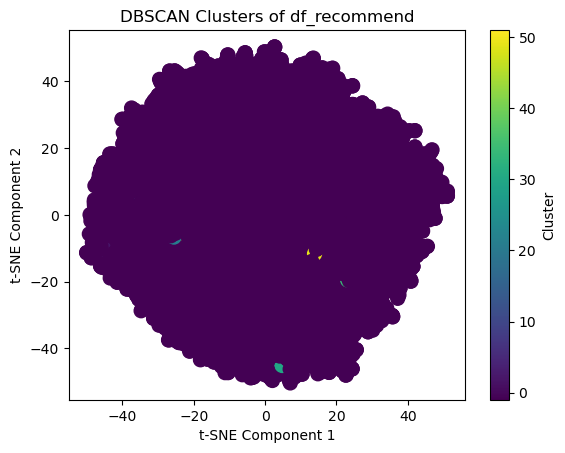

In [30]:
from sklearn.cluster import DBSCAN

# Fit DBSCAN to df_recommend_scaled
dbscan = DBSCAN(eps=0.5, min_samples=3)
df_recommend['cluster'] = dbscan.fit_predict(df_recommend_scaled)

# Visualize DBSCAN clusters
plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=df_recommend['cluster'], cmap='viridis', s=100)
plt.title('DBSCAN Clusters of df_recommend')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

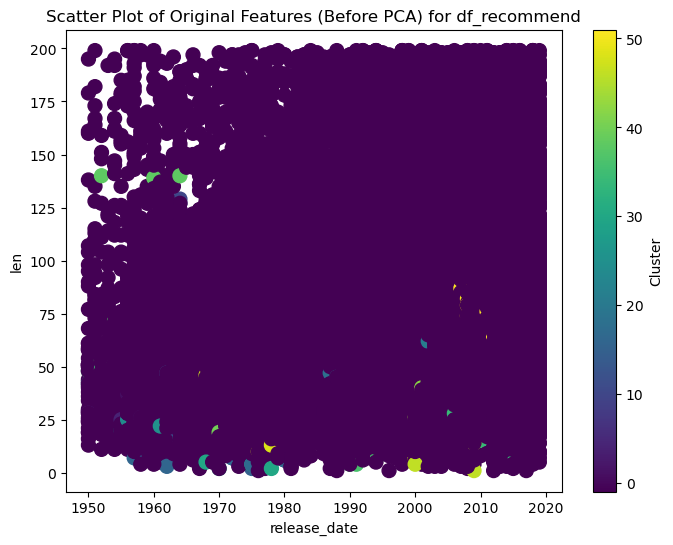

In [31]:
feature1 = df_recommend[numeric_cols[0]]
feature2 = df_recommend[numeric_cols[1]]

# Scatter plot of the two features
plt.figure(figsize=(8, 6))
plt.scatter(feature1, feature2, c=df_recommend['cluster'], cmap='viridis', s=100)
plt.title('Scatter Plot of Original Features (Before PCA) for df_recommend')
plt.xlabel(numeric_cols[0])
plt.ylabel(numeric_cols[1])
plt.colorbar(label='Cluster')
plt.show()

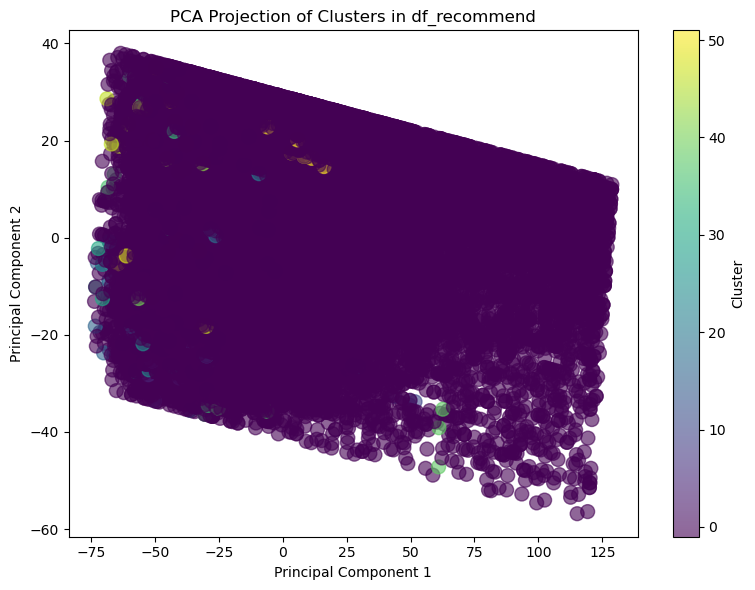

In [37]:
# Reduce to 2D using PCA
pca = PCA(n_components=2)  
components = pca.fit_transform(df_recommend[numeric_cols])

# Create scatter plot of the 2D components colored by cluster
plt.figure(figsize=(8, 6))
plt.scatter(
    components[:, 0], components[:, 1],
    c=df_recommend['cluster'],
    cmap='viridis',
    s=100,
    alpha=0.6
)
plt.title('PCA Projection of Clusters in df_recommend')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()



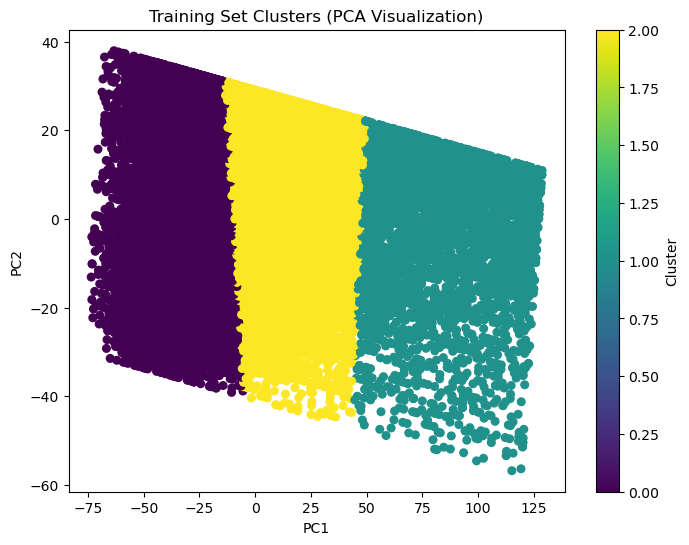

In [38]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
components = pca.fit_transform(df_model[numeric_cols])

plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], c=df_model['cluster'], cmap='viridis', s=30)
plt.title('Training Set Clusters (PCA Visualization)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()
